In [1]:
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
import IPython
import IPython.display as ipd
import tensorflow as tf
import librosa as lb
import os
from tensorflow import keras
from sklearn.model_selection import train_test_split

2022-12-03 08:53:31.938589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path = '/Users/nkkaushal/Documents/Fall22/ECS_271/Project/dataset/GTZAN_data/genres_original/'
labels = [a.name for a in os.scandir(path) if a.is_dir()]
indices = [i for i in range(len(labels))]
lenlabels = len(labels)
onehot = tf.one_hot(indices, lenlabels)
onehot_dict = {label:np.array(onehot[i,:]) for i, label in enumerate(labels)}
print(labels)
for dist_item, dict_value in onehot_dict.items():
    print(dist_item, dict_value)
total_files = 0
for folder in labels:
    files = os.listdir(path+folder)
    for file in files:
        if file.split('.')[-1] == 'wav':
            total_files += 1
print(f'files: {total_files}')

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
pop [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
metal [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
disco [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
blues [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
reggae [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
classical [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
rock [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
hiphop [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
country [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
jazz [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
files: 1000


In [4]:
features = 1 
NUMBER_OF_FILES = total_files
augmented_features = 4
slices = 3
M = NUMBER_OF_FILES * slices * (augmented_features) 

In [5]:
def read_sample(file):
    y, sr = lb.load(file)
    return y, sr


def data_augmentation(audio_sample, sr):
    
    updated_data = list()
  
    samples = np.array_split(audio_sample, slices)
    
    for sample_ in samples:
       
        updated_data.append(sample_)

        for n_steps in [4,6]:
            updated_data.append(lb.effects.pitch_shift(sample_, sr,n_steps))


        white_noise = np.random.randn(len(sample_))
        updated_data.append(sample_ + 0.004*white_noise)
    
    return updated_data

def read_audio_files(path, folders):

    folder = folders[0]
    files = os.listdir(path+folder)
    input_len = 0
    for file in files:
        if file.split('.')[-1] == 'wav':
            audio_sample, sr = read_sample(path+folder+'/'+file)
            input_len = len(audio_sample) // slices
            break
        
    
    return input_len


def retrieve_frames(audio_sample, sr):
    mel_spect = lb.feature.melspectrogram(audio_sample, sr)
    return mel_spect.shape[1]
    
    
def read_dataset(path, folders):
    
    input_len = read_audio_files(path, folders)
    
    raw_x = np.zeros((M, input_len))
    raw_y = np.zeros((M, 10))
    print(raw_x.shape, raw_y.shape)
    i = 0
    for folder in folders:
        print(f"Reading {folder}")
        files = os.listdir(path+folder)
        for file in files:
            
            if file.split('.')[-1] == 'wav':
                audio_sample, sr = read_sample(path+folder+'/'+file)
                aug_samples = data_augmentation(audio_sample, sr)
                for sample_ in aug_samples: 
                    
                    if len(sample_) > input_len:
                        sample_ = sample_[:input_len]
                    else:
                        sample_ = np.pad(sample_, (0, max(0, input_len - len(sample_))))
                    raw_x[i,:] = sample_
                    raw_y[i,:] = onehot_dict[folder]
                    i += 1
    print('Samples read: ', i)
    return raw_x, raw_y, sr
    
def data_prep(raw_x, sr):
    
    totalcount = retrieve_frames(raw_x[0,:], sr)
    X = np.zeros((M, 128, totalcount, features))

    for i in range(M):
        audio_sample = raw_x[i,:]
        spectro = lb.feature.melspectrogram(audio_sample, sr)
        spect = lb.power_to_db(spectro, ref=1.0)
        normalized_spectogram = normalize(spect)
        X[i,:,:,0] = normalized_spectogram

                
    return X

In [ ]:
raw_x, raw_y, sr = read_dataset(path, labels)
np.save('/Users/nkkaushal/Documents/Fall22/ECS_271/Project/dataset/2dcnn_features/X_features', raw_x)
np.save('/Users/nkkaushal/Documents/Fall22/ECS_271/Project/dataset/2dcnn_features/Y_features', raw_y)

In [6]:
#This code cell is used once we save the prepared data
raw_x = np.load('/Users/nkkaushal/Documents/Fall22/ECS_271/Project/dataset/2dcnn_features/X_features.npy')
raw_y = np.load('/Users/nkkaushal/Documents/Fall22/ECS_271/Project/dataset/2dcnn_features/Y_features.npy')
_,sr = read_sample(path+'blues/'+'blues.00000.wav')

In [ ]:
X = data_prep(raw_x, sr)
Y = np.copy(raw_y)

In [ ]:
x_train, x_test_valid, y_train, y_test_valid = train_test_split(X,Y, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_test_valid,y_test_valid, test_size=0.5)

In [14]:
input_shape = (X.shape[1], X.shape[2], X.shape[3])
inputs = keras.Input(shape=input_shape) 
x = preprocessing.Resizing(128, 128)(inputs)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)


x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)


x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation='softmax')(x)

In [15]:
model = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 431, 1)]     0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                             

In [17]:
epochs = 20

history = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    shuffle=True)

Epoch 1/20
300/300 [==============================] - 110s 365ms/step - loss: 2.0916 - accuracy: 0.2226 - val_loss: 1.8299 - val_accuracy: 0.3550
Epoch 2/20
300/300 [==============================] - 96s 321ms/step - loss: 1.7788 - accuracy: 0.3523 - val_loss: 1.5982 - val_accuracy: 0.4342
Epoch 3/20
300/300 [==============================] - 96s 320ms/step - loss: 1.5929 - accuracy: 0.4206 - val_loss: 1.3540 - val_accuracy: 0.5058
Epoch 4/20
300/300 [==============================] - 97s 322ms/step - loss: 1.4910 - accuracy: 0.4584 - val_loss: 1.2728 - val_accuracy: 0.5450
Epoch 5/20
300/300 [==============================] - 99s 328ms/step - loss: 1.3936 - accuracy: 0.5020 - val_loss: 1.2408 - val_accuracy: 0.5717
Epoch 6/20
300/300 [==============================] - 109s 363ms/step - loss: 1.3126 - accuracy: 0.5285 - val_loss: 1.1918 - val_accuracy: 0.5983
Epoch 7/20
300/300 [==============================] - 120s 401ms/step - loss: 1.2406 - accuracy: 0.5581 - val_loss: 1.0935 - val

In [18]:
model.evaluate(x=x_test, y=y_test)

38/38 [==============================] - 4s 97ms/step - loss: 0.6441 - accuracy: 0.7825


[0.6441159248352051, 0.7825000286102295]

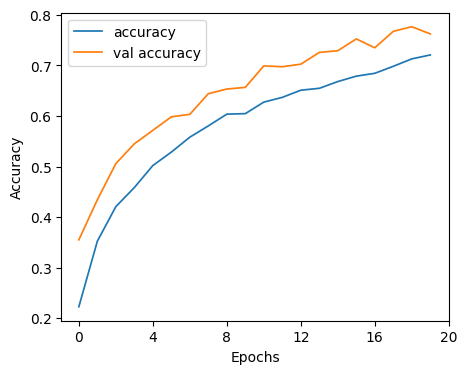

In [22]:
epochs = 20
hist_acc = history.history['accuracy'] 
hist_val_acc = history.history['val_accuracy'] 

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(epochs), hist_acc, label='accuracy', lw=1.25)
ax.plot(range(epochs), hist_val_acc, label='val accuracy', lw=1.25)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_xticks([i for i in range(0, epochs+1,4)])
ax.legend()
plt.savefig("./cnn64_acc_epochs.png", dpi=150)

plt.show()

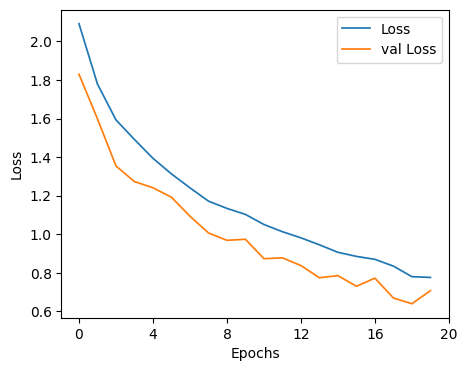

In [23]:
epochs = 20
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(epochs), loss, label='Loss', lw=1.25)
ax.plot(range(epochs), val_loss, label='val Loss', lw=1.25)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_xticks([i for i in range(0, epochs+1,4)])
ax.legend()
plt.savefig("./cnn64_loss_epochs.png", dpi=150)

plt.show()